In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torchsummary import summary # Print summary of models, pip install torchsummary
cuda = torch.device('cuda')
torch.cuda.is_available()

True

In [3]:
DATA_FOLDER = './data'

## Load Data

In [4]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.Resize((64,64)),
         transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [5]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [6]:
# import matplotlib.pyplot as plt
# plt.imshow(data.train_data[7], cmap='gray')

## Networks

In [7]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        ndf = 128 # Channel size of conv layers are based on this value
        
        self.hidden0 = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(in_channels=n_out, out_channels=ndf, kernel_size=4,
                     stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.hidden1 = nn.Sequential(
            # state size (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2,
                     padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.hidden2 = nn.Sequential(
            # state size (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2,
                     padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.hidden3 = nn.Sequential(
            # state size (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2,
                     padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            # state size (ndf*8) x 2 x 2
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1,
                      padding=0),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)
    return vectors.view(vectors.size(0), 1, 64, 64)

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        ngf = 128 # channel size of hidden layers are scaled based on this value
        
        self.hidden0 = nn.Sequential(
            # state size (n_features) x 1 x 1
            nn.ConvTranspose2d(n_features, ngf*8, kernel_size=4,
                              stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )
        self.hidden1 = nn.Sequential(      
            # state size (ngf*8) x 2 x 2
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True)
        )
        self.hidden2 = nn.Sequential(
            # state size (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True)
        )
        self.hidden3 = nn.Sequential(
            # state size (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.out = nn.Sequential(
            # state size (ngf*4) x 14 x 14
            nn.ConvTranspose2d(ngf, 1, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, batch_size, 1, 1))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [9]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [10]:
summary(generator, (100,1,1))
summary(discriminator, (1,64,64))
# fake_data = generator(noise(100))
# print(fake_data.size())
# discriminator.forward(fake_data).size()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           2,048
             Tanh-14            [-1, 1,

## Optimization

In [11]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, .999))
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, .999))

# Loss function (Binary Cross Entropy)
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

## Training

In [12]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [13]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

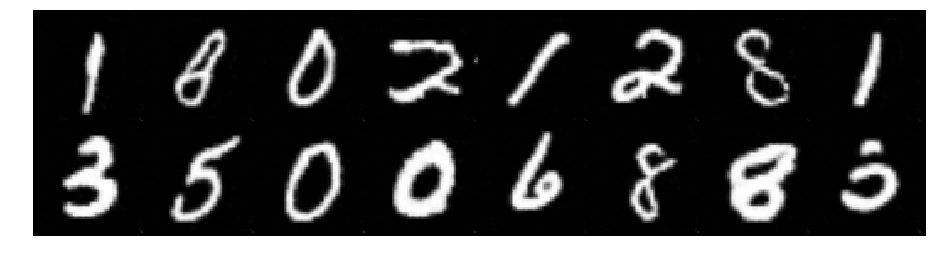

Epoch: [77/200], Batch Num: [500/600]
Discriminator Loss: 27.6310, Generator Loss: 0.0000
D(x): 1.0000, D(G(z)): 1.0000


KeyboardInterrupt: 

In [15]:
%%time
logger = Logger(model_name='Vanilla_GAN', data_name='MNIST')
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
#         real_data = Variable(images_to_vectors(real_batch))
        
        if torch.cuda.is_available(): 
            real_data = real_batch.cuda()
        else:
            real_data = real_batch
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)